# Data Exploration

Here, we will be performing an exhaustive analysis in order to gain insights Into the Data.

## Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
import seaborn as sns
import plotly.io as pio
from IPython.display import Image

In [2]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from df_cleaner import DfCleaner
from df_outlier import DfOutlier
from dvc_helper import DvcHelper
from vis_plotly import VisPlotly
from vis_seaborn import VisSeaborn
from df_overview import DfOverview

2021-07-28 14:10:20,114 — DfCleaner — DEBUG — Loaded successfully!
2021-07-28 14:10:20,129 — DfOutlier — DEBUG — Loaded successfully!
2021-07-28 14:10:20,264 — DfOverview — DEBUG — Loaded successfully!


In [4]:
sn = VisSeaborn()


## Data

In [5]:
dvc_helper = DvcHelper()

In [6]:
df_store = dvc_helper.read_csv('../data/clean_store.csv')
df_train = dvc_helper.read_csv('../data/clean_train.csv')
df_test = dvc_helper.read_csv('../data/clean_test.csv')

2021-07-28 14:10:20,357 — DfHelper — DEBUG — file read as csv
2021-07-28 14:10:20,815 — DfHelper — DEBUG — file read as csv
2021-07-28 14:10:20,848 — DfHelper — DEBUG — file read as csv


In [7]:
stores_types = ["Store type A", "Store type B", "Store type C", "Store type D"]
state_holidays = [ "Normal Day", "Public holiday", "Easter holiday", "Christmas"] 
school_holidays = ["School is closed", "School is open"]
assortment = [ "Basic", "Extra", "Extended"] 
promo = ["Not participating", "Participating"]
store_open = ["Closed", "Open"]

## Comparing Test and Train data

In [8]:
train_data = df_train.copy()
test_data = df_test.copy()

A good place to start will be to check if the test data is representative of the training data.

In [9]:
def compare_test_train(train_data, test_data, feature, title):
  fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
  ax[0].set_title("Train " + title)
  sns.countplot(x=feature, data=train_data, ax=ax[0])
  ax[1].set_title("Test " + title)
  sns.countplot(x=feature, data=test_data, ax=ax[1])
  fig.subplots_adjust(wspace=0.3)
  fig.show()

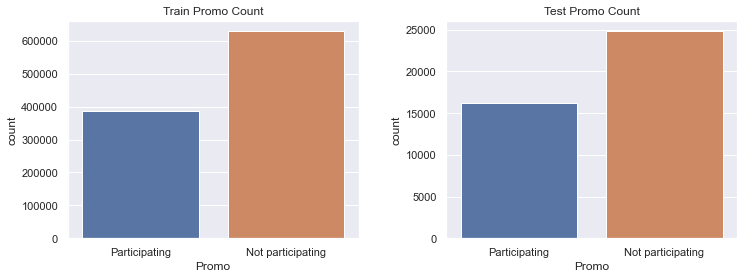

In [10]:
train_data["Promo"] = train_data["Promo"].apply(lambda x: promo[x])
test_data["Promo"] = test_data["Promo"].apply(lambda x: promo[x])
compare_test_train(train_data, test_data, 'Promo', "Promo Count")

As we can see stores participating in promotion are in similar proportion in trainig and test data.

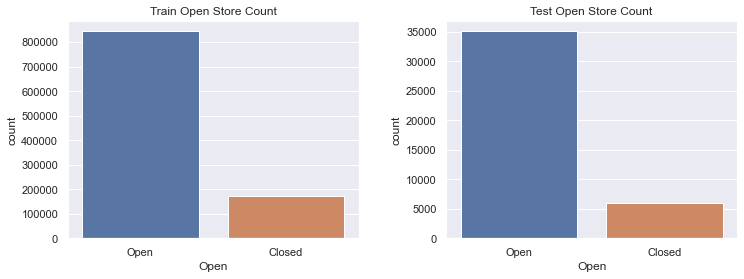

In [11]:
train_data["Open"] = train_data["Open"].apply(lambda x: store_open[x])
test_data["Open"] = test_data["Open"].apply(lambda x: store_open[x])
compare_test_train(train_data, test_data, 'Open', "Open Store Count")

Here also there is similar proportion between training and test data in number of stores open and closed.

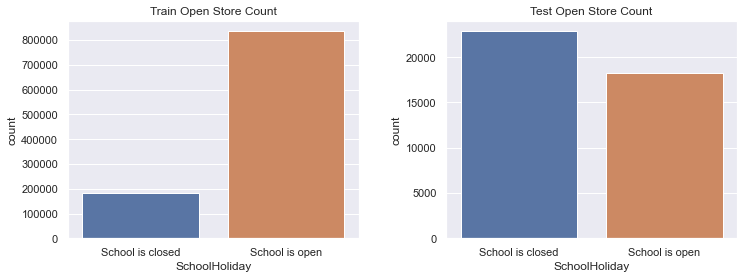

In [12]:
train_data["SchoolHoliday"] = train_data["SchoolHoliday"].apply(lambda x: school_holidays[x])
test_data["SchoolHoliday"] = test_data["SchoolHoliday"].apply(lambda x: school_holidays[x])
compare_test_train(train_data, test_data, 'SchoolHoliday', "Open Store Count")

This will be the first problem in correctly pridicting sales for test data. On our test data
Schools are more closed than open. This is not normal, the more representative data is the training data, in which there are far more days school are open than closed.

In [13]:
state_holiday_train = train_data.groupby(['StateHoliday']).agg({'StateHoliday': ['count']})
state_holiday_train.columns = ['count']
state_holiday_train = state_holiday_train.reset_index()
state_holiday_train["StateHoliday"] = state_holiday_train["StateHoliday"].apply(lambda x: state_holidays[x])
state_holiday_train

,StateHoliday,count
0,Normal Day,986159
1,Public holiday,20260
2,Easter holiday,6690
3,Christmas,4100


In [14]:
state_holiday_test = df_test.groupby(['StateHoliday']).agg({'StateHoliday': ['count']})
state_holiday_test.columns = ['count']
state_holiday_test = state_holiday_test.reset_index()
state_holiday_test["StateHoliday"] = state_holiday_test["StateHoliday"].apply(lambda x: state_holidays[x])
state_holiday_test

,StateHoliday,count
0,Normal Day,40908
1,Public holiday,180


This is the other problem in the test data. For the training data the proportion of the
proportion of normal days to public holiday a is 0.02. This mean for every 100 normal days we have 2 public holidays. But for the test data its 0.004,which is for 1000 normal days 4 public holidays. The other problem is Easter and Christmas are not in the test data.

## Joining store and train datasets

Now I will join Store and train data. Further analysis will be done using the joint columns.
I will also add day, month and year columns from the date column.

In [15]:
df_train_store = pd.merge(df_train.reset_index(), df_store, how='inner', on='Store')
df_train_store.shape

(1017209, 22)

In [16]:
df_train_store['Date'] = pd.DatetimeIndex(df_train_store['Date'])
df_train_store['Year'] = pd.DatetimeIndex(df_train_store['Date']).year
df_train_store['Month'] = pd.DatetimeIndex(df_train_store['Date']).month
df_train_store['Day'] = pd.DatetimeIndex(df_train_store['Date']).day
df_train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   index                      1017209 non-null  int64         
 1   Store                      1017209 non-null  int64         
 2   DayOfWeek                  1017209 non-null  int64         
 3   Date                       1017209 non-null  datetime64[ns]
 4   Sales                      1017209 non-null  int64         
 5   Customers                  1017209 non-null  int64         
 6   Open                       1017209 non-null  int64         
 7   Promo                      1017209 non-null  int64         
 8   StateHoliday               1017209 non-null  int64         
 9   SchoolHoliday              1017209 non-null  int64         
 10  StoreType                  1017209 non-null  int64         
 11  Assortment                 1017209 no

## Seasonality

Lets start by looking for seasonality in the data.

In [35]:
df = df_train_store.copy()

In [18]:
df["StoreType"] = df["StoreType"].apply(lambda x: stores_types[x])
store_type_df = df.groupby('StoreType').agg({'Customers': 'mean', 'Sales': 'mean'})
store_type_df = store_type_df.reset_index()
store_type_df


,StoreType,Customers,Sales
0,Store type A,640.03,5640.54
1,Store type B,1321.56,9198.32
2,Store type C,663.82,5668.12
3,Store type D,501.29,5611.88


Store type B has more than doubles other store in avarage customers count and has almost the double of other store in avarage sales.

In [19]:
date_df = df.groupby('Year').agg({'Customers': 'mean', 'Sales': 'mean'})
date_df = date_df.reset_index()
date_df.head()

,Year,Customers,Sales
0,2013,607.24,5574.86
1,2014,620.08,5747.61
2,2015,603.79,5800.55


The store have similar avarage sales and average customers count through out the three years

In [20]:
def plot_trend(df, columns, feature, title, x_label="", y_label="", labels=['']):
  plt.figure(figsize=(18, 6))
  for i in range(len(columns)):
    sns.lineplot(x=df.index, y=df[columns[i]][feature], label=labels[i])
  plt.title(title, fontsize=15, fontweight='bold')
  plt.ylabel(x_label, fontsize=14)
  plt.xlabel(y_label, fontsize=14)
  plt.show()

In [21]:
daily_trend = df.groupby(['Day', 'StoreType']).agg({'Customers': 'mean', 'Sales': 'mean'})
daily_trend = daily_trend.unstack().swaplevel(0, 1, 1).sort_index(1)

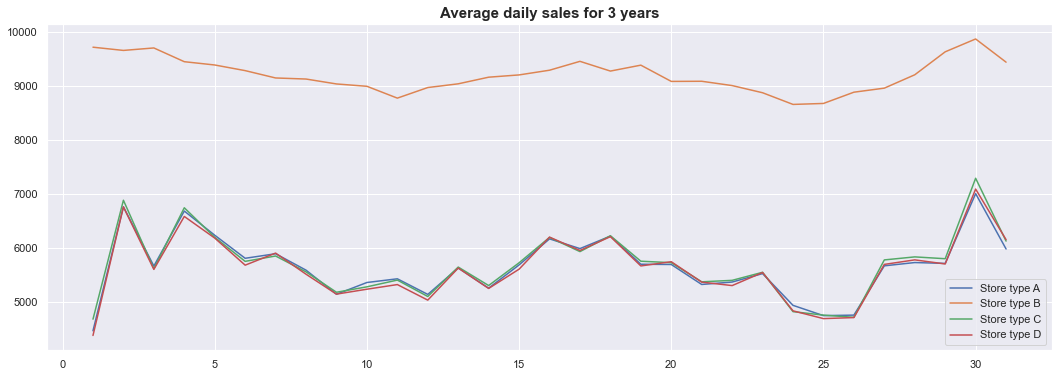

In [22]:
columns = ["Store type A", "Store type B", "Store type C", "Store type D"]
plot_trend(daily_trend, columns, 'Sales', 'Average daily sales for 3 years', labels=columns)

Here we can see there is a verry similar trend in throught a month between the stores. 
Store B has more sales but still the shape of the graph is similar.

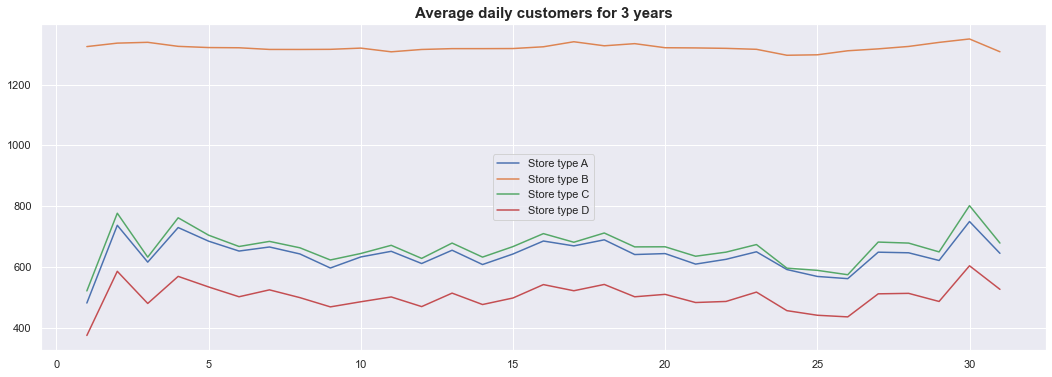

In [23]:
plot_trend(daily_trend, columns, 'Customers', 'Average daily customers for 3 years', labels=columns)

We can observe there is a similarity between the average sales and average number of customers.

In [24]:
monthly_trend = df.groupby(['Month', 'StoreType']).agg( {'Customers': 'mean', 'Sales': 'mean'})
monthly_trend = monthly_trend.unstack().swaplevel(0, 1, 1).sort_index(1)

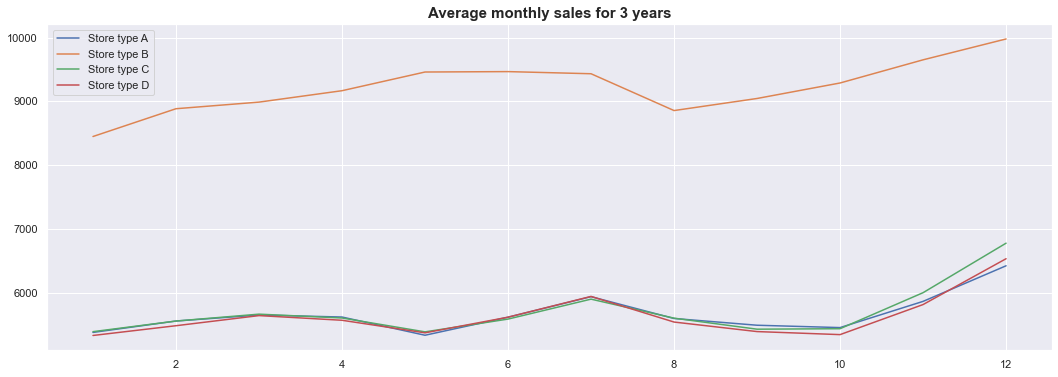

In [25]:
plot_trend(monthly_trend, columns, 'Sales', 'Average monthly sales for 3 years', labels=columns)

We can see the high points in sales are Aprill, Jully and December.
To understand the reasons behind this we should consider the fact that Rosman store is located in germeny.
This are the mainly holidays in germeny.
- January: New Year’s Day(Neujahrstag)
- April: Good Friday(Karfreitag)
- April: Easter Monday(Ostermontag)
- May: Labor Day(Maifeiertag)
- May: Ascension Day(Christi Himmelfahrt, 40 days after Easter)
- May: Whit Monday(Pfingstmontag) – seventh Monday after Easter.
- October: Day of German Unity(Tag der Deutschen Einheit)
- October: Reformation Day(Reformationstag) – generally a regional holiday in

Lets check in our data to confirm

In [36]:
df["StateHoliday"] = df["StateHoliday"].apply(lambda x: state_holidays[x])
df["SchoolHoliday"] = df["SchoolHoliday"].apply(lambda x: school_holidays[x])

In [44]:
public_holiday = df[["Month"]].loc[df["StateHoliday"] == state_holidays[1]]
easter_holiday = df[["Month"]].loc[df["StateHoliday"] == state_holidays[2]]
christmas_holiday = df[["Month"]].loc[df["StateHoliday"] == state_holidays[3]]

In [46]:
print("Public Hollydays are in months: ", np.sort(public_holiday["Month"].unique()))
print("Easter is in months: ", np.sort(easter_holiday["Month"].unique()))
print("Chrismass is in month: ", np.sort(christmas_holiday["Month"].unique()))

Public Hollydays are in months:  [ 1  5  6  8 10 11]
Easter is in months:  [3 4]
Chrismass is in month:  [12]


This confirms our assumption that increase in sells is due to holiday shopping. There other Interesting point is, salles increase throughout the stores leading to this holidays and 
there is decline in sells after this holidays.

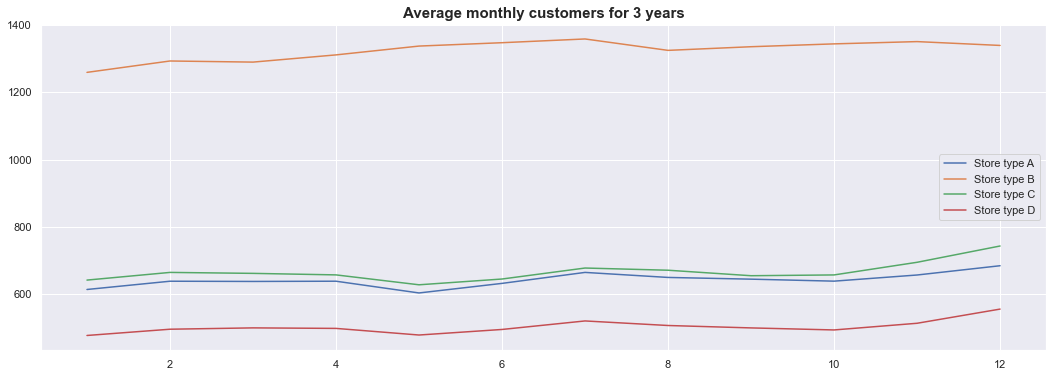

In [ ]:
plot_trend(monthly_trend, columns, 'Customers', 'Average monthly customers for 3 years', labels=columns)

here also we see similarities between sells and number of customers. 
Next we will explore this more in depth.

## Corelation

In [ ]:
corr_all = df_train_store[['Open', 'Promo', 'Promo2', 'Sales', 'Customers', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                           'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].corr()
corr_all

In [ ]:
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 12))
heatmap = sns.heatmap(corr_all, mask=mask, square=True, linewidths=.5,
                      vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt='.2f')
heatmap.set_title('Correlation between features', fontdict={'fontsize': 15}, pad=12)
fig.show()


In [ ]:
overall_trend = df_train_store.groupby(['Date', 'StateHoliday']).agg(
    {'Customers': 'mean', 'Sales': 'mean'})
overall_trend = overall_trend.unstack().swaplevel(0, 1, 1).sort_index(1)


In [ ]:
hollyday_trend = df_train_store.groupby(['Day', "StateHoliday", "SchoolHoliday"]).agg(
    {'Customers': 'mean', 'Sales': 'mean'})
hollyday_trend.reset_index(inplace=True)

In [ ]:
fig = px.scatter(hollyday_trend, x="Day", y="Sales", color="SchoolHoliday")
Image(pio.to_image(fig, format='png', width=1200))

sales and number of customers


In [ ]:
fig = px.scatter(df_train_store, x="Customers", y="Sales", color="SchoolHoliday")
Image(pio.to_image(fig, format='png', width=1200))

In [ ]:
fig = px.scatter(df_train_store, x="Customers", y="Sales", color="StateHoliday")
Image(pio.to_image(fig, format='png', width=1200))

Impact of Promo on customers and sales

In [ ]:
overall_trend = df_train_store.groupby(['Promo', 'Promo2',]).agg(
    {'Customers': 'mean', 'Sales': 'mean'})
overall_trend

In [ ]:
sns.factorplot(data=df_train_store, 
               x='Month', 
               y="Sales",
               palette='plasma',
               hue='Year',
               row='Promo',
               col='Promo2', 
               color='green')

In [ ]:
sns.factorplot(data=df_train_store,
               x='Month',
               y="Customers",
               palette='plasma',
               hue='Year',
               row='Promo',
               col='Promo2',
               color='green')

In [ ]:
Promo 1 Aroound November and December.

In [ ]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x='StoreType', y='Sales', data=weekdays_data, ax=axis1).set(
    title='Barplot showing Sales Distribution over Storetypes')
sns.barplot(x='StoreType', y='Sales', data=weekend_data, ax=axis2)


In [ ]:
open_days_data = df_train_store[df_train_store['Open'] == 1]
closed_days_data = df_train_store[df_train_store['Open'] == 0]

In [ ]:
weekly_data = df_train_store.groupby(['DayOfWeek']).agg({'DayOfWeek': ['count']})
weekly_data.columns = ['count']
weekly_data = weekly_data.reset_index()
weekly_data

Now lets look at Hollydays

In [ ]:
hollyday_trend = df_train_store.groupby(['Date', 'StateHoliday']).agg(
    {'Customers': 'mean', 'Sales': 'mean'})
hollyday_trend.reset_index(inplace=True)

In [ ]:
fig = px.histogram(
    hollyday_trend,
      x="Date",
      y="Sales",
      color="StateHoliday",
      barmode="group",
      title=f"Ordered Italy, Spain, France",
      category_orders={"Country Name":["Italy","Spain","France"]}
      )
Image(pio.to_image(fig, format='png', width=1200))


In [ ]:
df = df_train_store.query("Store==2"  )

In [ ]:
fig = px.line(df, x="Date", y="Sales", title='Life expectancy in Canada', color='Year')
Image(pio.to_image(fig, format='png', width=1200))


In [ ]:
sns.pairplot(data=df_train_store[['Sales', 'Month', 'Customers']])


In [ ]:
corr_all = df_train_store.drop('Open', axis=1).corr()

In [ ]:
sns.pairplot(data=df_train_store[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear']])

In [ ]:
hollyday_trend = df_train_store.groupby(['Date', 'StateHoliday']).agg(
    {'Customers': 'mean', 'Sales': 'mean'})
hollyday_trend.reset_index(inplace=True)


In [ ]:
fig = px.histogram(
    hollyday_trend,
    x="Date",
    y="Sales",
    color="StateHoliday",
    barmode="group",
    title=f"Ordered Italy, Spain, France",
      category_orders={"Country Name": ["Italy", "Spain", "France"]}
)
Image(pio.to_image(fig, format='png', width=1200))


In [ ]:
new_df["Store A Sales"] = date_store_type_df['a'][['Sales']].resample('W').mean()
new_df["Store B Sales"] = date_store_type_df['b'][['Sales']].resample('W').mean()
new_df["Store C Sales"] = date_store_type_df['c'][['Sales']].resample('W').mean()
new_df["Store D Sales"] = date_store_type_df['d'][['Sales']].resample('W').mean()
columns = ["Store A Sales", "Store B Sales", "Store C Sales", "Store D Sales"]
plot_trend(new_df, columns ,'Monthly Trend Across Store Types', "Monthly Sales", "Datetime", labels=columns)

In [ ]:
new_df["Store A Sales"] = date_store_type_df['a'][['Sales']].resample('M').mean()
new_df["Store B Sales"] = date_store_type_df['b'][['Sales']].resample('M').mean()
new_df["Store C Sales"] = date_store_type_df['c'][['Sales']].resample('M').mean()
new_df["Store D Sales"] = date_store_type_df['d'][['Sales']].resample('M').mean()
columns = ["Store A Sales", "Store B Sales", "Store C Sales", "Store D Sales"]
plot_trend(new_df, columns ,'Monthly Trend Across Store Types', "Monthly Sales", "Datetime", labels=columns)

Customers count throught the year

In [ ]:
plot_trend(date_df, ['Customers'], 'Daily Trend', "Customers Count", "Datetime")

In [ ]:
plot_trend(date_df[['Customers']].resample('W').mean(), ['Customers'], 'Weekly Trend', "Customers Count", "Datetime")

In [ ]:
plot_trend(date_df[['Customers']].resample('M').mean(), ['Customers'], 'Monthly Trend', "Customers Count", "Datetime")

In [ ]:
monthly_df = date_store_type_df['b'][["Sales"]].resample('M').sum()
plot_trend(monthly_df, 'Monthly Trend')

In [ ]:
new_df["Store A Customers"] = date_store_type_df['a'][['Customers']]
new_df["Store B Customers"] = date_store_type_df['b'][['Customers']]
new_df["Store C Customers"] = date_store_type_df['c'][['Customers']]
new_df["Store D Customers"] = date_store_type_df['d'][['Customers']]
columns = ["Store A Customers", "Store B Customers", "Store C Customers", "Store D Customers"]
plot_trend(new_df, columns, 'Daily Trend Across Store Types', "Daily Customers Count", "Datetime", labels=columns)

In [ ]:
new_df["Store A Customers"] = date_store_type_df['a'][['Customers']].resample('W').mean()
new_df["Store B Customers"] = date_store_type_df['b'][['Customers']].resample('W').mean()
new_df["Store C Customers"] = date_store_type_df['c'][['Customers']].resample('W').mean()
new_df["Store D Customers"] = date_store_type_df['d'][['Customers']].resample('W').mean()
columns = ["Store A Customers", "Store B Customers", "Store C Customers", "Store D Customers"]
plot_trend(new_df, columns, 'Weekly Trend Across Store Types', "Weekly Customers Count", "Datetime", labels=columns)

In [ ]:
new_df["Store A Customers"] = date_store_type_df['a'][['Customers']].resample('M').mean()
new_df["Store B Customers"] = date_store_type_df['b'][['Customers']].resample('M').mean()
new_df["Store C Customers"] = date_store_type_df['c'][['Customers']].resample('M').mean()
new_df["Store D Customers"] = date_store_type_df['d'][['Customers']].resample('M').mean()
columns = ["Store A Customers", "Store B Customers", "Store C Customers", "Store D Customers"]
plot_trend(new_df, columns, 'Monthly Trend Across Store Types', "Monthly Customers Count", "Datetime", labels=columns)


Seosonality during holidys

In [ ]:
train_store_df['StateHoliday'] 


In [ ]:
date_holiday_type_df = train_store_df.groupby(['Date', 'StateHoliday']).agg(
    {'Customers': 'mean', 'Sales': 'mean'})
date_holiday_type_df = date_store_type_df.unstack().swaplevel(0, 1, 1).sort_index(1)
date_holiday_type_df